In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_S5G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Wed Mar 31 12:42:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:2E:00.0 Off |                  N/A |
|103%   84C    P0   102W / 250W |      0MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:2F:00.0 Off |                  N/A |
| 95%   

In [10]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/rubato/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [3]:
save_dir = '/data/save/model_S5G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json     save_1095000  save_147866  save_232353  save_324281  save_733439
save_100000   save_110000   save_150000  save_235000  save_325000  save_75000
save_1000000  save_1100000  save_151422  save_239735  save_330000  save_80000
save_100189   save_1105000  save_155000  save_239809  save_335000  save_800000
save_100481   save_1110000  save_160000  save_240000  save_340000  save_85000
save_1005000  save_1115000  save_165000  save_242209  save_344332  save_90000
save_100728   save_1120000  save_170000  save_245000  save_345000  save_900000
save_1010000  save_1125000  save_170017  save_247546  save_350000  save_944231
save_1015000  save_1130000  save_175000  save_248082  save_353107  save_945000
save_1020000  save_1135000  save_177763  save_250000  save_355000  save_95000
save_1025000  save_1140000  save_180000  save_255000  save_360000  save_950000
save_1028820  save_1140116  save_184582  save_258351  save_362255  save_955000
save_1029824  save_115000   save_185000  save_258531  sav

In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 1140116

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 283.0MiB
TTS size 195.3MiB
MelEncoder size 65.3MiB
MelDecoder size 119.0MiB
loaded : 1140116
1140116
done


In [6]:
trainset = LJDataset(tts_hparams, split='train')
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.07498140335083008


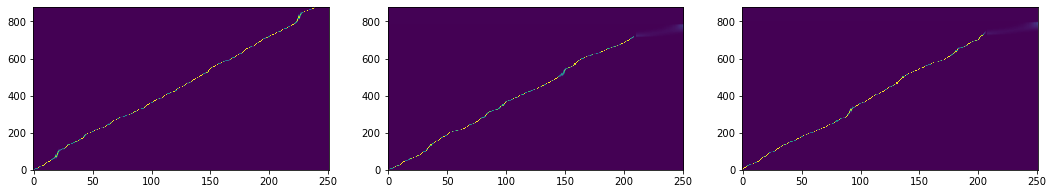

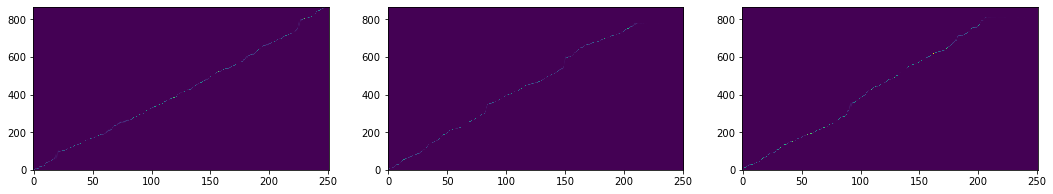

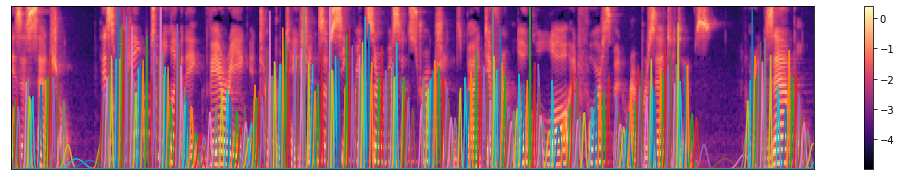

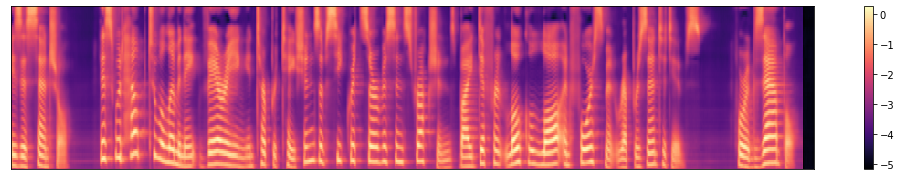

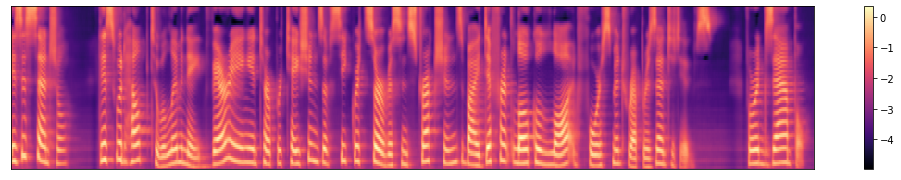

tensor(-18.4207, device='cuda:0')
tensor(0.5041, device='cuda:0')
step : 1230001 stt : 0.0025 tts : 0.2887 recon : 0.0330 kl : 0.0082 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.5736, device='cuda:0')
step : 1230002 stt : 0.0026 tts : 0.3119 recon : 0.0317 kl : 0.0080 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.5000, device='cuda:0')
step : 1230003 stt : 0.0026 tts : 0.2671 recon : 0.0290 kl : 0.0077 beta : 1.0000
tensor(-0.7333, device='cuda:0')
tensor(0.4819, device='cuda:0')
step : 1230004 stt : 0.0045 tts : 0.3016 recon : 0.0356 kl : 0.0079 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.4434, device='cuda:0')
step : 1230005 stt : 0.0033 tts : 0.3363 recon : 0.0306 kl : 0.0076 beta : 1.0000
tensor(-2.1672, device='cuda:0')
tensor(0.6538, device='cuda:0')
step : 1230006 stt : 0.0033 tts : 0.2963 recon : 0.0333 kl : 0.0078 beta : 1.0000
tensor(-2.0928, device='cuda:0')
tensor(0.4922, device='cuda:0')
step : 1230007 stt : 0.0038 tts : 0.2816 recon : 

tensor(-0.5090, device='cuda:0')
tensor(0.3775, device='cuda:0')
step : 1230057 stt : 0.0020 tts : 0.3107 recon : 0.0296 kl : 0.0071 beta : 1.0000
tensor(-1.8692, device='cuda:0')
tensor(0.4939, device='cuda:0')
step : 1230058 stt : 0.0039 tts : 0.3236 recon : 0.0254 kl : 0.0068 beta : 1.0000
tensor(-0.2823, device='cuda:0')
tensor(0.3586, device='cuda:0')
step : 1230059 stt : 0.0019 tts : 0.2851 recon : 0.0237 kl : 0.0066 beta : 1.0000
tensor(-2.5079, device='cuda:0')
tensor(0.3653, device='cuda:0')
step : 1230060 stt : 0.0018 tts : 0.3160 recon : 0.0291 kl : 0.0071 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.4084, device='cuda:0')
step : 1230061 stt : 0.0035 tts : 0.2721 recon : 0.0255 kl : 0.0067 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.3597, device='cuda:0')
step : 1230062 stt : 0.0010 tts : 0.2614 recon : 0.0261 kl : 0.0068 beta : 1.0000
tensor(-1.5232, device='cuda:0')
tensor(0.3448, device='cuda:0')
step : 1230063 stt : 0.0005 tts : 0.2738 recon : 0.

tensor(-1.7170, device='cuda:0')
tensor(0.4061, device='cuda:0')
step : 1230113 stt : 0.0011 tts : 0.2721 recon : 0.0241 kl : 0.0063 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.3590, device='cuda:0')
step : 1230114 stt : 0.0015 tts : 0.2715 recon : 0.0252 kl : 0.0065 beta : 1.0000
tensor(-1.0054, device='cuda:0')
tensor(0.5891, device='cuda:0')
step : 1230115 stt : 0.0010 tts : 0.2950 recon : 0.0262 kl : 0.0066 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.3804, device='cuda:0')
step : 1230116 stt : 0.0014 tts : 0.3117 recon : 0.0275 kl : 0.0067 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.4720, device='cuda:0')
step : 1230117 stt : 0.0016 tts : 0.3071 recon : 0.0295 kl : 0.0069 beta : 1.0000
tensor(0.1952, device='cuda:0')
tensor(0.4075, device='cuda:0')
step : 1230118 stt : 0.0005 tts : 0.2536 recon : 0.0252 kl : 0.0064 beta : 1.0000
tensor(-2.3625, device='cuda:0')
tensor(0.4435, device='cuda:0')
step : 1230119 stt : 0.0011 tts : 0.3211 recon : 0.

tensor(-18.4207, device='cuda:0')
tensor(0.4450, device='cuda:0')
step : 1230169 stt : 0.0009 tts : 0.2910 recon : 0.0236 kl : 0.0059 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.3300, device='cuda:0')
step : 1230170 stt : 0.0014 tts : 0.2463 recon : 0.0223 kl : 0.0057 beta : 1.0000
tensor(-0.7927, device='cuda:0')
tensor(0.3411, device='cuda:0')
step : 1230171 stt : 0.0006 tts : 0.2635 recon : 0.0223 kl : 0.0058 beta : 1.0000
tensor(-1.3854, device='cuda:0')
tensor(0.3342, device='cuda:0')
step : 1230172 stt : 0.0013 tts : 0.2608 recon : 0.0224 kl : 0.0058 beta : 1.0000
tensor(-2.2117, device='cuda:0')
tensor(0.3597, device='cuda:0')
step : 1230173 stt : 0.0013 tts : 0.2748 recon : 0.0252 kl : 0.0061 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.5291, device='cuda:0')
step : 1230174 stt : 0.0007 tts : 0.2473 recon : 0.0231 kl : 0.0058 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.3624, device='cuda:0')
step : 1230175 stt : 0.0012 tts : 0.2586 recon : 

tensor(-1.1846, device='cuda:0')
tensor(0.2821, device='cuda:0')
step : 1230225 stt : 0.0008 tts : 0.2488 recon : 0.0255 kl : 0.0063 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.4270, device='cuda:0')
step : 1230226 stt : 0.0007 tts : 0.2545 recon : 0.0267 kl : 0.0064 beta : 1.0000
tensor(0.4031, device='cuda:0')
tensor(0.3834, device='cuda:0')
step : 1230227 stt : 0.0014 tts : 0.2429 recon : 0.0238 kl : 0.0061 beta : 1.0000
tensor(-18.4207, device='cuda:0')
tensor(0.5358, device='cuda:0')
step : 1230228 stt : 0.0010 tts : 0.3011 recon : 0.0233 kl : 0.0058 beta : 1.0000
tensor(-18.4207, device='cuda:0')


In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 500 == 0:
            display.clear_output()
            
            index = 0
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            try:
                _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
                batch_size = _tts_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
                batch_size = _stt_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                plt.figure(figsize=[18, 3])
                _x = batch['mels'].data.cpu().numpy()
                librosa.display.specshow(_x[index])
                plt.colorbar()

                for i in range(_stt_alignments.shape[1]):
                    plt.plot(_stt_alignments[index, i] * 100)

                plt.show()

                plt.figure(figsize=[18, 3])
                _y = tts_outputs['pred'].data.cpu().numpy()
                librosa.display.specshow(_y[index])
                plt.colorbar()
                plt.show()

                plt.figure(figsize=[18, 3])
                _s = samples.data.cpu().numpy()
                librosa.display.specshow(_s[index, :, :_y.shape[2]])
                plt.colorbar()
                plt.show()
            except:
                pass
                      
        step += 1
        

In [ ]:
logger.save(step, model, optimizer)

In [10]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 11:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [12]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(171520,)


0.014089584350585938


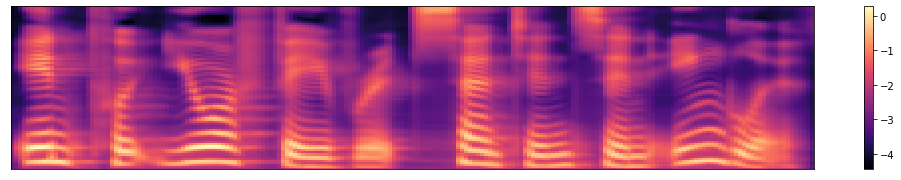

(51712,)


In [18]:
from g2p_en import G2p

g2p = G2p()

t0 = time.time()
text = "Input your favorite sentence in English"
text_array = g2p(text)
text = ""
for t in text_array:
    text += t

text_utf = text.encode()
ts = [0]
for t in text_utf:
    ts.append(t)
ts.append(0)    
utf8_values = np.array(ts)
t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
model.eval()
with torch.no_grad():
    
    samples, time_dict = model.inference(t, None, None, temperature=1.0)
    _s = samples.data.cpu().numpy()
    t1 = time.time()
    print(t1 - t0)
    plt.figure(figsize=[18, 3])
    librosa.display.specshow(_s[0])
    plt.colorbar()
    plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)